# isc Import and Plotting

This example shows how to measure a Cyclic Voltammetry with Python and then import and plot the data using the library [matplotlib](https://matplotlib.org/).

In the example the CV measurement and the file transfer is not explained anymore, there are separate examples for this topic:
* [File exchange example](https://github.com/Zahner-elektrik/Thales-Remote-Python/blob/main/Examples/FileExchangeEIS/FileExchangeEIS.ipynb)
* [Cyclic voltammetry example](https://github.com/Zahner-elektrik/Thales-Remote-Python/blob/main/Examples/CyclicVoltammetry/CyclicVoltammetry.ipynb)



In [1]:
import sys
from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import ThalesRemoteScriptWrapper
from thales_remote.file_interface import ThalesFileInterface

from zahner_analysis.file_import.isc_import import IscImport

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter


# Connect Python to the already launched Thales-Software

In [ ]:

if __name__ == "__main__":
    zenniumConnection = ThalesRemoteConnection()
    zenniumConnection.connectToTerm("localhost", "ScriptRemote")

    zahnerZennium = ThalesRemoteScriptWrapper(zenniumConnection)
    zahnerZennium.forceThalesIntoRemoteScript()

    zahnerZennium.calibrateOffsets()

# Establish the connection for the transfer of measurement files

With the class [ThalesFileInterface](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface) a connection to the Term/Thales software via network is established. It provides the methods to control the file transfer.

The filter is set so that only isc files, the results of the impedance measurement, are sent.

In [3]:
    fileInterface = ThalesFileInterface("localhost")
    fileInterface.disableSaveReceivedFilesToDisk()
    fileInterface.enableKeepReceivedFilesInObject()
    fileInterface.enableAutomaticFileExchange(fileExtensions="*.isc")


'128,FileExchange,ON'

# Setting the parameters for the measurement

The parameters for the measurement are subsequently set. For the maximum current, a current is estimated for the first measurement.

In [4]:
    zahnerZennium.setCVStartPotential(0)
    zahnerZennium.setCVUpperReversingPotential(0.2)
    zahnerZennium.setCVLowerReversingPotential(-0.2)
    zahnerZennium.setCVEndPotential(0)

    zahnerZennium.setCVStartHoldTime(2)
    zahnerZennium.setCVEndHoldTime(2)

    zahnerZennium.setCVCycles(1.5)
    zahnerZennium.setCVSamplesPerCycle(400)

    zahnerZennium.setCVMaximumCurrent(0.0002)
    zahnerZennium.setCVMinimumCurrent(-0.0002)

    zahnerZennium.setCVOhmicDrop(0)

    zahnerZennium.disableCVAutoRestartAtCurrentOverflow()
    zahnerZennium.disableCVAutoRestartAtCurrentUnderflow()
    zahnerZennium.disableCVAnalogFunctionGenerator()

    zahnerZennium.setCVNaming("individual")
    zahnerZennium.setCVOutputPath(r"C:\THALES\temp\cv")


'OK\r'

# Perform the measurement

For each of the 3 scan rates in the **scanRatesForMeasurement** array, CV measurements are performed.

After the measurement the new maximum current is determined for the next measurement from the maximum current of the last measurement.

The measurement data is imported using the [IscImport](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.isc_import.IscImport) class and the binary measurement data from the [ThalesFileInterface](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface) class. The current values are read out with method getCurrentArray(). From the current values the absolute value is formed and the maximum value is then used for the next measurement with the factor 3.

In [5]:
    scanRatesForMeasurement = [0.5, 1, 2]

    for scanRate in scanRatesForMeasurement:
        zahnerZennium.setCVOutputFileName("cv_{:d}mVs".format(int(scanRate * 1000)))
        zahnerZennium.setCVScanRate(scanRate)

        zahnerZennium.checkCVSetup()

        zahnerZennium.measureCV()

        """
        Determine the maximum current for the next measurement
        from the maximum current of the last CV measurement.
        """
        latestMeasurement = IscImport(fileInterface.getLatestReceivedFile().binaryData)
        maximumCurrent = max(abs(latestMeasurement.getCurrentArray()))

        zahnerZennium.setCVMaximumCurrent(maximumCurrent * 3)
        zahnerZennium.setCVMinimumCurrent(maximumCurrent * -3)


After the measurement, the connection to the term is closed.

In [6]:
    zenniumConnection.disconnectFromTerm()
    fileInterface.close()
    

# Importing the measurement data

With the class [IscImport](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.isc_import.IscImport) the file can be imported into Python.

There are two possibilities for this. Either you pass the path of the file as in the example with the variable **iscFileFromDisc**. Or you pass the binary file content, which comes for example from the ThalesFileInterface.

In [7]:
    iscFileFromDisc = IscImport(r"C:\THALES\temp\cv\cv_1000mVs.isc")

    iscFiles = [IscImport(file.binaryData) for file in fileInterface.getReceivedFiles()]

    for iscFile in iscFiles:
        print(f"{iscFile.getScanRate()} V/s\tmeasurement finished at {iscFile.getMeasurementEndDateTime()}")
    

0.5 V/s	measurement finished at 2022-05-25 11:34:23
1.0 V/s	measurement finished at 2022-05-25 11:34:36
2.0 V/s	measurement finished at 2022-05-25 11:34:50


With the methods [getTimeArray()](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.isc_import.IscImport.getTimeArray), [getCurrentArray()](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.isc_import.IscImport.getCurrentArray) and [getVoltageArray()](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.isc_import.IscImport.getVoltageArray) you get the measurement data from the IscImport object.

The measurement data are then displayed in this example with matplotlib.

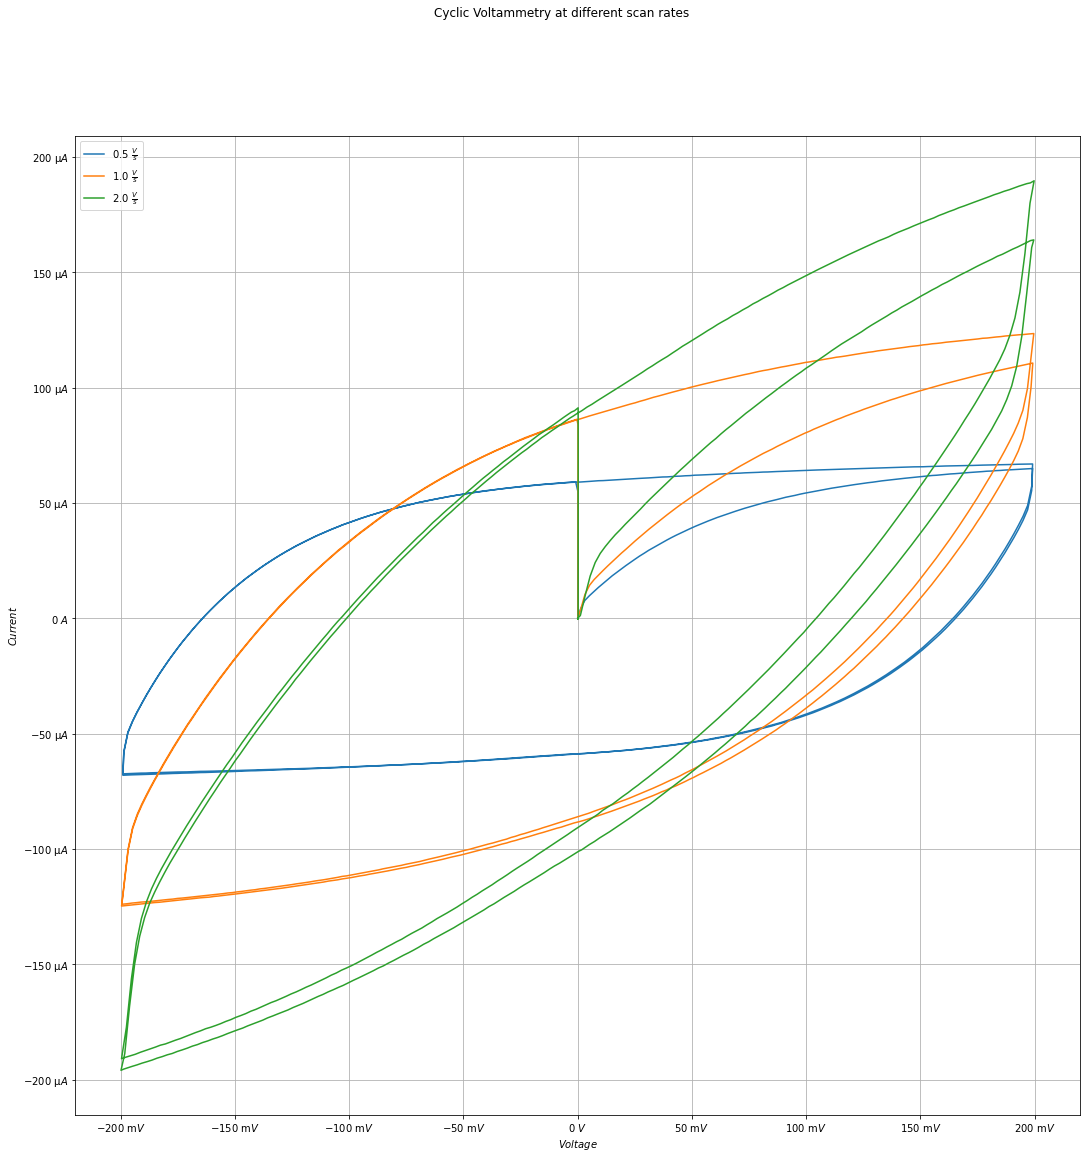

In [8]:
    figCV, (axis) = plt.subplots(1, 1)
    figCV.suptitle("Cyclic Voltammetry at different scan rates")

    for iscFile in iscFiles:
        axis.plot(iscFile.getVoltageArray(), iscFile.getCurrentArray(),label=f"{iscFile.getScanRate()} $\\frac{{V}}{{s}}$")

    axis.grid(which="both")
    axis.xaxis.set_major_formatter(EngFormatter(unit="$V$"))
    axis.yaxis.set_major_formatter(EngFormatter(unit="$A$"))
    axis.set_xlabel(r"$Voltage$")
    axis.set_ylabel(r"$Current$")
    axis.legend()

    figCV.set_size_inches(18, 18)
    plt.show()
    figCV.savefig("CV.svg")